In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import numpy as np
import math
import sys
import math

In [2]:
patch_size = (16, 16)      # Tamaño de cada patch (afecta n_embd)
img_size = (224, 224)      # Resolución de entrada (afecta seq_len)
batch_size = 16            # Tamaño del batch (afecta memoria)

n_embd = 3 * 16 * 16       # 768 - Dimensiones del embedding por patch
seq_len = 14 * 14          # 196 - Número total de patches
n_heads = 4*4               # Número de cabezas de atención
num_classes = 5            # Número de clases de tu dataset
dropout = 0.3              # Regularización para evitar overfitting

learning_rate = 1e-4       # Tasa de aprendizaje
weight_decay = 1e-4        # Regularización L2
optimizer = "Adam"        # Optimizador (Adam, AdamW, SGD)

max_epochs = 3             # Épocas máximas
precision = 32             # Precisión (16 para GPU, 32 para CPU)
accumulate_grad_batches = 1 # Acumulación de gradientes

In [3]:
class LazyAttnDataset(Dataset):
    def __init__(self, data_dir, patch_size=(16, 16), img_size=(224, 224)):
        self.files, self.labels = [], []
        self.patch_size = patch_size
        self.img_size = img_size
        
        for label, classname in enumerate(sorted(os.listdir(data_dir))):
            class_dir = os.path.join(data_dir, classname)
            if not os.path.isdir(class_dir):
                continue
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.files.append(os.path.join(class_dir, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        img = Image.open(self.files[ix]).convert("RGB")
        img = img.resize(self.img_size)
        img = torch.tensor(np.array(img)).float().permute(2, 0, 1) / 255
        
        C, H, W = img.shape
        hh, ww = self.patch_size
        
        # Verificar que las dimensiones sean divisibles
        assert H % hh == 0, f"Height {H} not divisible by patch height {hh}"
        assert W % ww == 0, f"Width {W} not divisible by patch width {ww}"
        
        patches = img.unfold(1, hh, hh).unfold(2, ww, ww)
        patches = patches.permute(1, 2, 0, 3, 4).contiguous()
        patches = patches.view(-1, C * hh * ww)
        label = torch.tensor(self.labels[ix]).long()
        
        return patches, label


In [4]:
from torch.utils.data import DataLoader

train_dataset = LazyAttnDataset(r"D:\Ciencias\Dataset Residuos solidos\data\train", patch_size=patch_size, img_size=img_size)
val_dataset = LazyAttnDataset(r"D:\Ciencias\Dataset Residuos solidos\data\val", patch_size=patch_size, img_size=img_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Tomar un batch
imgs, labels = next(iter(train_loader))  # imgs.shape = [batch_size, C, H, W]

print("Batch shape:", imgs.shape)  # e.g., [32, 3, 224, 224]

# Aplanar cada imagen del batch
imgs_flat = imgs.view(imgs.size(0), -1)
print("Batch aplanado:", imgs_flat.shape)  # e.g., [32, 150528]

# Mostrar la primera imagen
print("Primera imagen (tensor):")
print(imgs[0])  # shape [3, 224, 224]

print("#"*30)

# Primera imagen aplanada
print("Primera imagen aplanada:")
print(imgs_flat[0])  # shape [150528]


Batch shape: torch.Size([16, 196, 768])
Batch aplanado: torch.Size([16, 150528])
Primera imagen (tensor):
tensor([[0.5059, 0.5137, 0.4667,  ..., 0.3412, 0.3765, 0.5765],
        [0.6667, 0.6510, 0.6510,  ..., 0.6039, 0.6667, 0.7137],
        [0.6627, 0.7020, 0.6745,  ..., 0.6314, 0.5765, 0.6275],
        ...,
        [0.6549, 0.5059, 0.6275,  ..., 0.5608, 0.4902, 0.3216],
        [0.6980, 0.7608, 0.8196,  ..., 0.7451, 0.6667, 0.6980],
        [0.8314, 0.8078, 0.8118,  ..., 0.7373, 0.6588, 0.6510]])
##############################
Primera imagen aplanada:
tensor([0.5059, 0.5137, 0.4667,  ..., 0.7373, 0.6588, 0.6510])


In [6]:
class DesechosDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=16, patch_size=(16, 16), img_size=(224, 224)):
        super().__init__()
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.img_size = img_size

    def setup(self, stage=None):
        self.train_ds = LazyAttnDataset(
            r"D:\Ciencias\Dataset Residuos solidos\data\train",
            patch_size=self.patch_size,
            img_size=self.img_size
        )
        self.val_ds = LazyAttnDataset(
            r"D:\Ciencias\Dataset Residuos solidos\data\val",
            patch_size=self.patch_size,
            img_size=self.img_size
        )

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [7]:
imgsprueba = torch.rand(3,224,224)
print(imgsprueba.shape)

torch.Size([3, 224, 224])


In [8]:
#Creamos una imagen de prueba random
imgsprueba = torch.rand(3,224,224)  # RGB
C, H, W = imgsprueba.shape

#Definimos el tamaño de los patches
hh, ww = 16, 16

#Divide la imagen en patches no superpuestos de tamaño (hh, ww)
patches = imgsprueba.unfold(1, hh, hh).unfold(2, ww, ww)  # (C, 14, 14, 16, 16)
print(patches.shape)

#Reorganiza los parches para tenerlos en la forma (14, 14, C, 16, 16)
patches = patches.permute(1, 2, 0, 3, 4).contiguous()      # (14, 14, C, 16, 16)
print(patches.shape)

#Aplana cada parche a un vector de tamaño C*hh*ww
patches_flat = patches.view(-1, C*hh*ww) # (196, 768) (n_patches, patch_size)
print(patches_flat.shape)


torch.Size([3, 14, 14, 16, 16])
torch.Size([14, 14, 3, 16, 16])
torch.Size([196, 768])


In [9]:
#creamos el datamodule
attn_dm = DesechosDataModule(batch_size=batch_size, patch_size=patch_size, img_size=img_size)

#Configuramos el datamodule usando internamente el AttnDataset
attn_dm.setup()

In [10]:
#Probamos el dataloader

imgs, labels = next(iter(attn_dm.train_dataloader())) #obtenemos un batch

#Comprobamos las dimensiones
imgs.shape, labels.shape

(torch.Size([16, 196, 768]), torch.Size([16]))

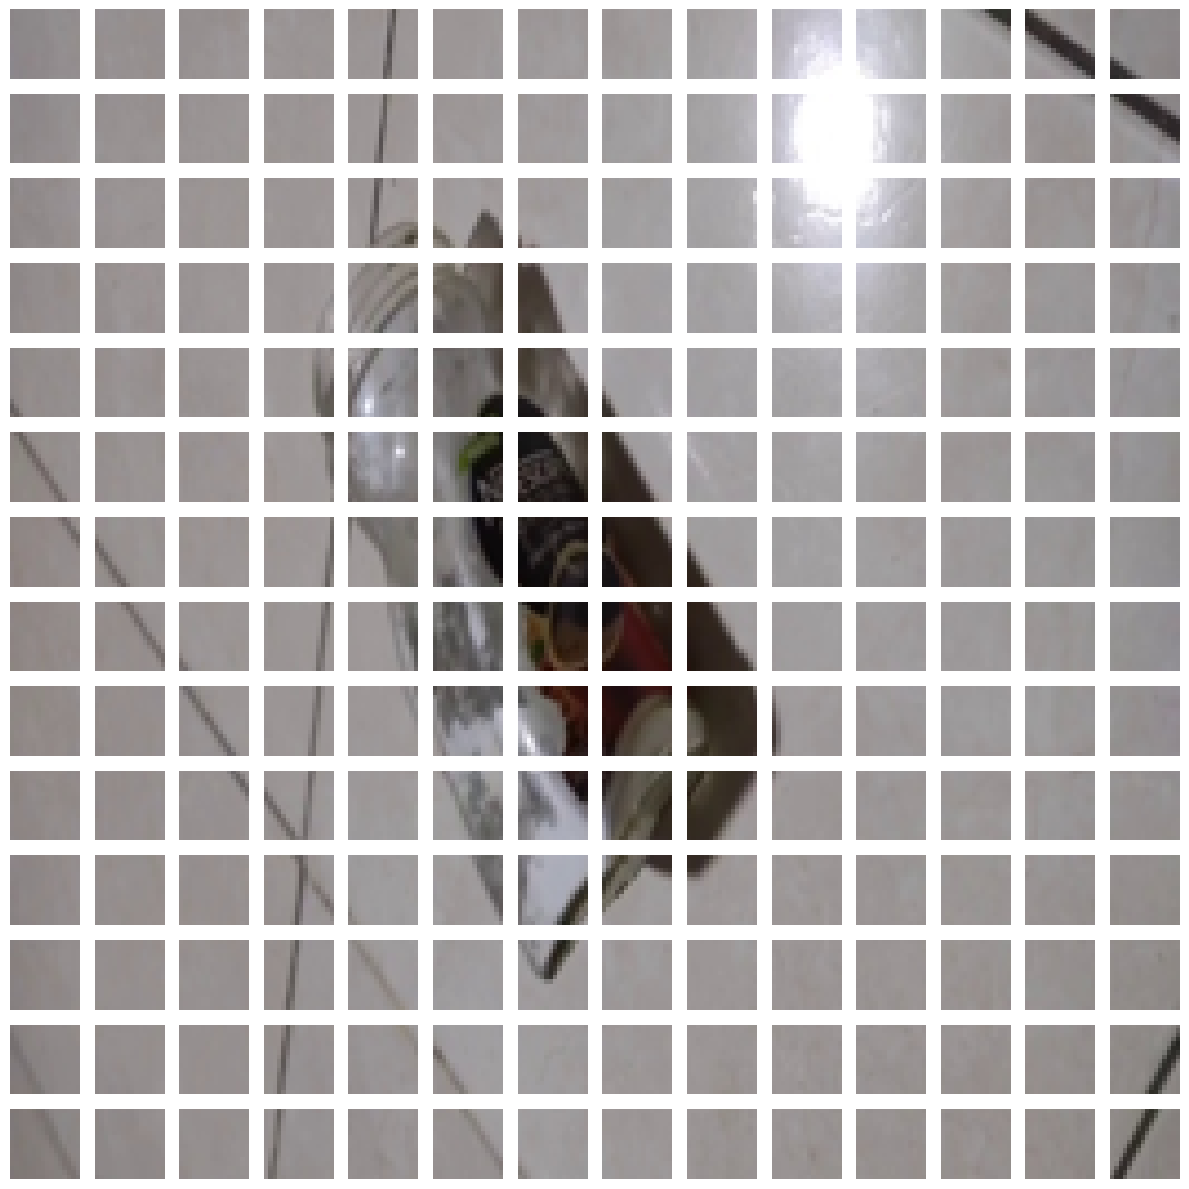

In [17]:
import matplotlib.pyplot as plt

# Tomamos un batch
patches_batch, labels = next(iter(attn_dm.train_dataloader()))  # (B, num_patches, C*hh*ww)
hh, ww = 16, 16 
C = 3

# Primer ejemplo del batch
patches = patches_batch[0]  # (196, 768)

# Grid 14x14 de todos los patches5
fig = plt.figure(figsize=(12,12))
for i in range(14):
    for j in range(14):
        idx = i*14 + j
        patch_flat = patches[idx]            # (768,)
        patch = patch_flat.view(C, hh, ww)   # (3,16,16)
        patch = patch.permute(1, 2, 0)       # (16,16,3)
        ax = plt.subplot(14, 14, idx+1)
        ax.imshow(patch.numpy())
        ax.axis('off')

plt.tight_layout()
plt.show()


In [12]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = n_embd // n_heads
        
        assert n_embd % n_heads == 0, "n_embd must be divisible by n_heads"
        
        # QKV combinado
        self.qkv = nn.Linear(n_embd, 3 * n_embd)  # Solo 1 capa lineal
        self.proj = nn.Linear(n_embd, n_embd)
        
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)
        self.scale = 1.0 / math.sqrt(self.head_dim)

    def forward(self, x):
        B, L, C = x.size()
        
        # QKV combinado - mucho más eficiente
        qkv = self.qkv(x).reshape(B, L, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, nh, L, hd)
        
        # Atención escalada
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        
        # Aplicar atención
        y = attn @ v  # (B, nh, L, hd)
        y = y.transpose(1, 2).reshape(B, L, C)  # Reensamblar
        
        return self.proj_dropout(self.proj(y))


In [ ]:
class EnhancedAttentionModel(pl.LightningModule):
    def __init__(self, n_embd=768, seq_len=196, n_heads=16, num_classes=5, dropout=0.3):
        super().__init__()
        self.save_hyperparameters()
        
        self.attn1 = MultiHeadAttention(n_embd, n_heads)
        self.ln1 = nn.LayerNorm(n_embd)
        self.dropout1 = nn.Dropout(dropout)
        
        self.attn2 = MultiHeadAttention(n_embd, n_heads)
        self.ln2 = nn.LayerNorm(n_embd)
        self.dropout2 = nn.Dropout(dropout)
        
        # POOLING GLOBAL en lugar de aplanar
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # MLP pequeño y eficiente
        self.mlp_head = nn.Sequential(
            nn.Linear(n_embd, 256),  # ← ¡Solo n_embd, no n_embd*seq_len!
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        B, L, C = x.size()
        
        # Bloques de atención
        x_attn = self.attn1(x)
        x = self.ln1(x + self.dropout1(x_attn))
        
        x_attn = self.attn2(x)
        x = self.ln2(x + self.dropout2(x_attn))
        
        # Pooling global sobre la secuencia
        x = x.transpose(1, 2)  # (B, C, L)
        x = self.pool(x)       # (B, C, 1)
        x = x.squeeze(-1)      # (B, C)
        
        return self.mlp_head(x)
    
    # comendato
    # def forward(self, x):
    #     B, L, C = x.size()
        
    #     # Primer bloque
    #     x_attn = self.attn1(x)
    #     x = self.ln1(x + self.dropout1(x_attn))
        
    #     # Segundo bloque
    #     x_attn = self.attn2(x)
    #     x = self.ln2(x + self.dropout2(x_attn))
        
    #     # Aplanar toda la secuencia (batch_size, n_embd * seq_len)
    #     x = x.reshape(B, -1)
    #     return self.mlp_head(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), 
            lr=1e-4,
            weight_decay=1e-4
        )

In [14]:
C = 3  # RGB

n_embd = C * patch_size[0] * patch_size[1]  # 3 * 16 * 16 = 768
seq_len = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])  # 14 * 14 = 196

print(f"Calculated dimensions:")
print(f"n_embd: {n_embd}")
print(f"seq_len: {seq_len}")
print(f"MLP input: {n_embd * seq_len}")  # 768 * 196 = 150528

Calculated dimensions:
n_embd: 768
seq_len: 196
MLP input: 150528


In [15]:
# Borra cachés y libera memoria
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

15

In [18]:
attn_dm = DesechosDataModule(
    batch_size=batch_size,
    patch_size=patch_size,
    img_size=img_size
)
attn_dm.setup()

model = EnhancedAttentionModel(
    n_embd=n_embd,
    seq_len=seq_len,
    n_heads=n_heads,
    num_classes=num_classes,
    dropout=dropout
)

trainer = pl.Trainer(
    max_epochs=max_epochs,  # Más épocas para mejor convergencia
    precision=16 if torch.cuda.is_available() else 32,
    accumulate_grad_batches=2,
    gradient_clip_val=1.0,
    enable_progress_bar=True,
    enable_model_summary=True,
    deterministic=True
)

trainer.fit(model, attn_dm)

d:\Programs\Python\3.12.7\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\Programs\Python\3.12.7\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are f

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

d:\Programs\Python\3.12.7\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


d:\Programs\Python\3.12.7\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 2501/2501 [07:42<00:00,  5.41it/s, v_num=9, train_loss=0.00424, train_acc=1.000, val_loss=0.127, val_acc=0.965]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2501/2501 [07:42<00:00,  5.40it/s, v_num=9, train_loss=0.00424, train_acc=1.000, val_loss=0.127, val_acc=0.965]


In [19]:
import torch

def save_model_with_metadata(model, trainer, config, save_path="model_with_metadata.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': trainer.optimizers[0].state_dict(),
        'hyperparameters': config,
        'epoch': trainer.current_epoch,
        'val_acc': trainer.callback_metrics.get('val_acc', 0.0),
        'val_loss': trainer.callback_metrics.get('val_loss', 0.0)
    }
    
    torch.save(checkpoint, save_path)
    print(f"Modelo con metadata guardado como: {save_path}")
    return save_path


In [20]:
# import sys
# import os

# # sys.path.append(os.path.abspath("."))
# # from functions.save_model import save_model_with_metadata

save_path = "desechos_model_2.pth"
config = {
    'patch_size': patch_size,
    'img_size': img_size,
    'n_embd': n_embd,
    'seq_len': seq_len,
    'num_classes': 5,
    'batch_size': batch_size,
    'max_epochs': max_epochs
}

metadata_path = save_model_with_metadata(model, trainer, config, save_path=save_path)

Modelo con metadata guardado como: desechos_model_2.pth


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from turtle import pd  # Esto parece un error, lo quito

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_from_dataframe(data):
    """Generar gráficas desde un DataFrame con los datos, incluyendo validation"""
    
    # Convertir a DataFrame si es una lista de strings
    if isinstance(data, list):
        # Parsear los datos
        rows = []
        for line in data:
            if line.strip():
                parts = line.split(',')
                if len(parts) >= 5:
                    row_data = {
                        'epoch': float(parts[0]),
                        'step': float(parts[1]),
                        'train_acc': float(parts[2]) if parts[2] else None,
                        'train_loss': float(parts[3]) if parts[3] else None
                    }
                    # Añadir validation metrics si existen
                    if len(parts) > 4 and parts[4].strip():
                        row_data['val_acc'] = float(parts[4])
                    if len(parts) > 5 and parts[5].strip():
                        row_data['val_loss'] = float(parts[5])
                    rows.append(row_data)
        df = pd.DataFrame(rows)
    else:
        df = data
    
    # Verificar si hay datos de validation
    has_validation = 'val_acc' in df.columns and not df['val_acc'].isna().all()
    
    # Crear gráficas - ahora 3x2 para incluir validation
    if has_validation:
        fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(18, 10))
        axes = np.vstack([axes, [None, None]])  # Añadir fila vacía para mantener estructura
    
    # Gráfica 1: Train Accuracy por step
    axes[0, 0].plot(df['step'], df['train_acc'], 'o-', markersize=3, linewidth=1, alpha=0.7, label='Train')
    if has_validation:
        axes[0, 0].plot(df['step'], df['val_acc'], 'o-', markersize=3, linewidth=1, alpha=0.7, label='Validation')
    axes[0, 0].set_title('Accuracy por Step')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Gráfica 2: Train Loss por step
    axes[0, 1].plot(df['step'], df['train_loss'], 'o-', color='red', markersize=3, linewidth=1, alpha=0.7, label='Train')
    if has_validation:
        axes[0, 1].plot(df['step'], df['val_loss'], 'o-', color='blue', markersize=3, linewidth=1, alpha=0.7, label='Validation')
    axes[0, 1].set_title('Loss por Step')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gráfica 3: Train vs Validation Accuracy por epoch
    epoch_metrics = df.groupby('epoch').agg({
        'train_acc': 'mean',
        'train_loss': 'mean'
    }).reset_index()
    
    if has_validation:
        val_epoch_metrics = df.groupby('epoch').agg({
            'val_acc': 'mean',
            'val_loss': 'mean'
        }).reset_index()
    
    axes[1, 0].plot(epoch_metrics['epoch'], epoch_metrics['train_acc'], 'o-', label='Train Accuracy', linewidth=2, markersize=6)
    if has_validation:
        axes[1, 0].plot(val_epoch_metrics['epoch'], val_epoch_metrics['val_acc'], 'o-', label='Validation Accuracy', linewidth=2, markersize=6)
    axes[1, 0].set_title('Accuracy: Train vs Validation por Época')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Gráfica 4: Train vs Validation Loss por epoch
    axes[1, 1].plot(epoch_metrics['epoch'], epoch_metrics['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=6, color='red')
    if has_validation:
        axes[1, 1].plot(val_epoch_metrics['epoch'], val_epoch_metrics['val_loss'], 'o-', label='Validation Loss', linewidth=2, markersize=6, color='blue')
    axes[1, 1].set_title('Loss: Train vs Validation por Época')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Gráfica 5: Gap de Generalización (solo si hay validation)
    if has_validation:
        gap_df = pd.merge(epoch_metrics, val_epoch_metrics, on='epoch')
        gap_df['acc_gap'] = gap_df['train_acc'] - gap_df['val_acc']
        gap_df['loss_gap'] = gap_df['val_loss'] - gap_df['train_loss']  # Positive gap means validation worse
        
        axes[2, 0].plot(gap_df['epoch'], gap_df['acc_gap'], 'o-', color='purple', linewidth=2, markersize=6)
        axes[2, 0].set_title('Gap de Generalización (Train Acc - Val Acc)')
        axes[2, 0].set_xlabel('Época')
        axes[2, 0].set_ylabel('Accuracy Gap')
        axes[2, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[2, 0].grid(True, alpha=0.3)
        
        # Gráfica 6: Ratio de Overfitting
        gap_df['overfitting_ratio'] = gap_df['acc_gap'] / gap_df['train_acc']
        axes[2, 1].plot(gap_df['epoch'], gap_df['overfitting_ratio'], 'o-', color='orange', linewidth=2, markersize=6)
        axes[2, 1].set_title('Ratio de Overfitting (Gap/Train Acc)')
        axes[2, 1].set_xlabel('Época')
        axes[2, 1].set_ylabel('Overfitting Ratio')
        axes[2, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[2, 1].grid(True, alpha=0.3)
    
    else:
        # Si no hay validation, mostrar distribuciones
        axes[2, 0].hist(df['train_acc'].dropna(), bins=20, alpha=0.7, edgecolor='black')
        axes[2, 0].set_title('Distribución de Train Accuracy')
        axes[2, 0].set_xlabel('Accuracy')
        axes[2, 0].set_ylabel('Frecuencia')
        axes[2, 0].axvline(df['train_acc'].mean(), color='red', linestyle='--', label=f'Mean: {df["train_acc"].mean():.3f}')
        axes[2, 0].legend()
        
        axes[2, 1].hist(df['train_loss'].dropna(), bins=20, alpha=0.7, edgecolor='black', color='red')
        axes[2, 1].set_title('Distribución de Train Loss')
        axes[2, 1].set_xlabel('Loss')
        axes[2, 1].set_ylabel('Frecuencia')
        axes[2, 1].axvline(df['train_loss'].mean(), color='blue', linestyle='--', label=f'Mean: {df["train_loss"].mean():.3f}')
        axes[2, 1].legend()
    
    plt.tight_layout()
    plt.savefig('complete_training_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Mostrar estadísticas completas
    print("📊 ESTADÍSTICAS COMPLETAS DE ENTRENAMIENTO:")
    print(f"   • Train Accuracy: {df['train_acc'].mean():.3f} ± {df['train_acc'].std():.3f}")
    print(f"   • Train Loss: {df['train_loss'].mean():.3f} ± {df['train_loss'].std():.3f}")
    
    if has_validation:
        print(f"   • Validation Accuracy: {df['val_acc'].mean():.3f} ± {df['val_acc'].std():.3f}")
        print(f"   • Validation Loss: {df['val_loss'].mean():.3f} ± {df['val_loss'].std():.3f}")
        print(f"   • Accuracy Gap: {gap_df['acc_gap'].mean():.3f} (train > val)")
        print(f"   • Best Validation Accuracy: {df['val_acc'].max():.3f}")
    
    print(f"   • Best Train Accuracy: {df['train_acc'].max():.3f}")
    print(f"   • Best Train Loss: {df['train_loss'].min():.3f}")
    
    return df

In [22]:
def load_and_preprocess_image(image_path, patch_size=(16, 16), img_size=(224, 224)):
    """
    Carga y preprocesa una imagen individual para el modelo de atención
    """
    # Cargar imagen
    img = Image.open(image_path).convert("RGB")
    
    # Redimensionar
    img = img.resize(img_size)
    
    # Convertir a tensor y normalizar
    img_tensor = torch.tensor(np.array(img)).float().permute(2, 0, 1) / 255
    
    # Extraer patches (igual que en el dataset)
    C, H, W = img_tensor.shape
    hh, ww = patch_size
    
    patches = img_tensor.unfold(1, hh, hh).unfold(2, ww, ww)
    patches = patches.permute(1, 2, 0, 3, 4).contiguous()
    patches = patches.view(-1, C * hh * ww)
    
    # Añadir dimensión de batch
    patches = patches.unsqueeze(0)  # (1, num_patches, C*hh*ww)
    
    return patches, img_tensor

In [23]:
def predict_single_image(model, image_path, patch_size=(16, 16), img_size=(224, 224)):
    # Cargar y preprocesar imagen
    patches, original_img = load_and_preprocess_image(image_path, patch_size, img_size)
    
    # Mover al dispositivo del modelo
    device = next(model.parameters()).device
    patches = patches.to(device)
    
    # Predecir
    with torch.no_grad():
        model.eval()
        pred = model(patches)
        pred_class = pred.argmax(dim=1).item()
        pred_probs = F.softmax(pred, dim=1)[0]  # Probabilidades
    
    return pred_class, pred_probs, original_img, patches

In [24]:
def visualize_prediction(image_path, model, class_names=None):
    # Hacer predicción
    pred_class, pred_probs, original_img, patches = predict_single_image(model, image_path)
    
    # Obtener nombres de clases (si están disponibles)
    if class_names is None:
        class_names = [f'Class {i}' for i in range(5)]
    
    # Crear figura
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Mostrar imagen original
    axes[0].imshow(original_img.permute(1, 2, 0).numpy())
    axes[0].set_title('Imagen Original', fontsize=14)
    axes[0].axis('off')
    
    # Mostrar probabilidades
    axes[1].barh(class_names, pred_probs.cpu().numpy())
    axes[1].set_xlabel('Probabilidad', fontsize=12)
    axes[1].set_title(f'Predicción: {class_names[pred_class]}', fontsize=14)
    axes[1].set_xlim(0, 1)
    
    # Añadir valores de probabilidad
    for i, prob in enumerate(pred_probs.cpu().numpy()):
        axes[1].text(prob + 0.01, i, f'{prob:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return pred_class, pred_probs


In [25]:
def visualize_patches_from_image(image_path, model, patch_size=(16, 16)):
    """
    Visualiza todos los patches de una imagen
    """
    # Cargar imagen
    patches, original_img = load_and_preprocess_image(image_path, patch_size)
    
    # Mover al dispositivo del modelo
    device = next(model.parameters()).device
    patches = patches.to(device)
    
    # Predecir
    with torch.no_grad():
        model.eval()
        pred = model(patches)
        pred_class = pred.argmax(dim=1).item()
    
    # Parámetros
    C, hh, ww = 3, patch_size[0], patch_size[1]
    num_patches = patches.shape[1]
    grid_size = int(num_patches ** 0.5)  # 14 para 224x224 con patches 16x16
    
    # Crear figura
    fig = plt.figure(figsize=(12, 12))
    
    # Mostrar todos los patches
    for i in range(grid_size):
        for j in range(grid_size):
            patch_idx = i * grid_size + j
            patch_flat = patches[0, patch_idx]  # (C*hh*ww,)
            patch = patch_flat.view(C, hh, ww).permute(1, 2, 0).cpu().numpy()
            
            ax = plt.subplot(grid_size, grid_size, patch_idx + 1)
            ax.imshow(patch)
            ax.axis('off')
            # ax.set_title(f'{i},{j}', fontsize=6)  # Opcional: coordenadas
    
    fig.suptitle(f'Predicción: Clase {pred_class}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [26]:
def load_model_complete(checkpoint_path, model_class=EnhancedAttentionModel):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    if 'hyperparameters' in checkpoint:
        config = checkpoint['hyperparameters']
        print("Cargando modelo con configuración:", config)
        
        model = model_class(
            n_embd=config['n_embd'],
            seq_len=config['seq_len'],
            num_classes=config['num_classes']
        )
        
        model.load_state_dict(checkpoint['model_state_dict'])
        
    else:
        model = torch.load(checkpoint_path)
    
    model.eval()
    print("Modelo cargado exitosamente!")
    return model

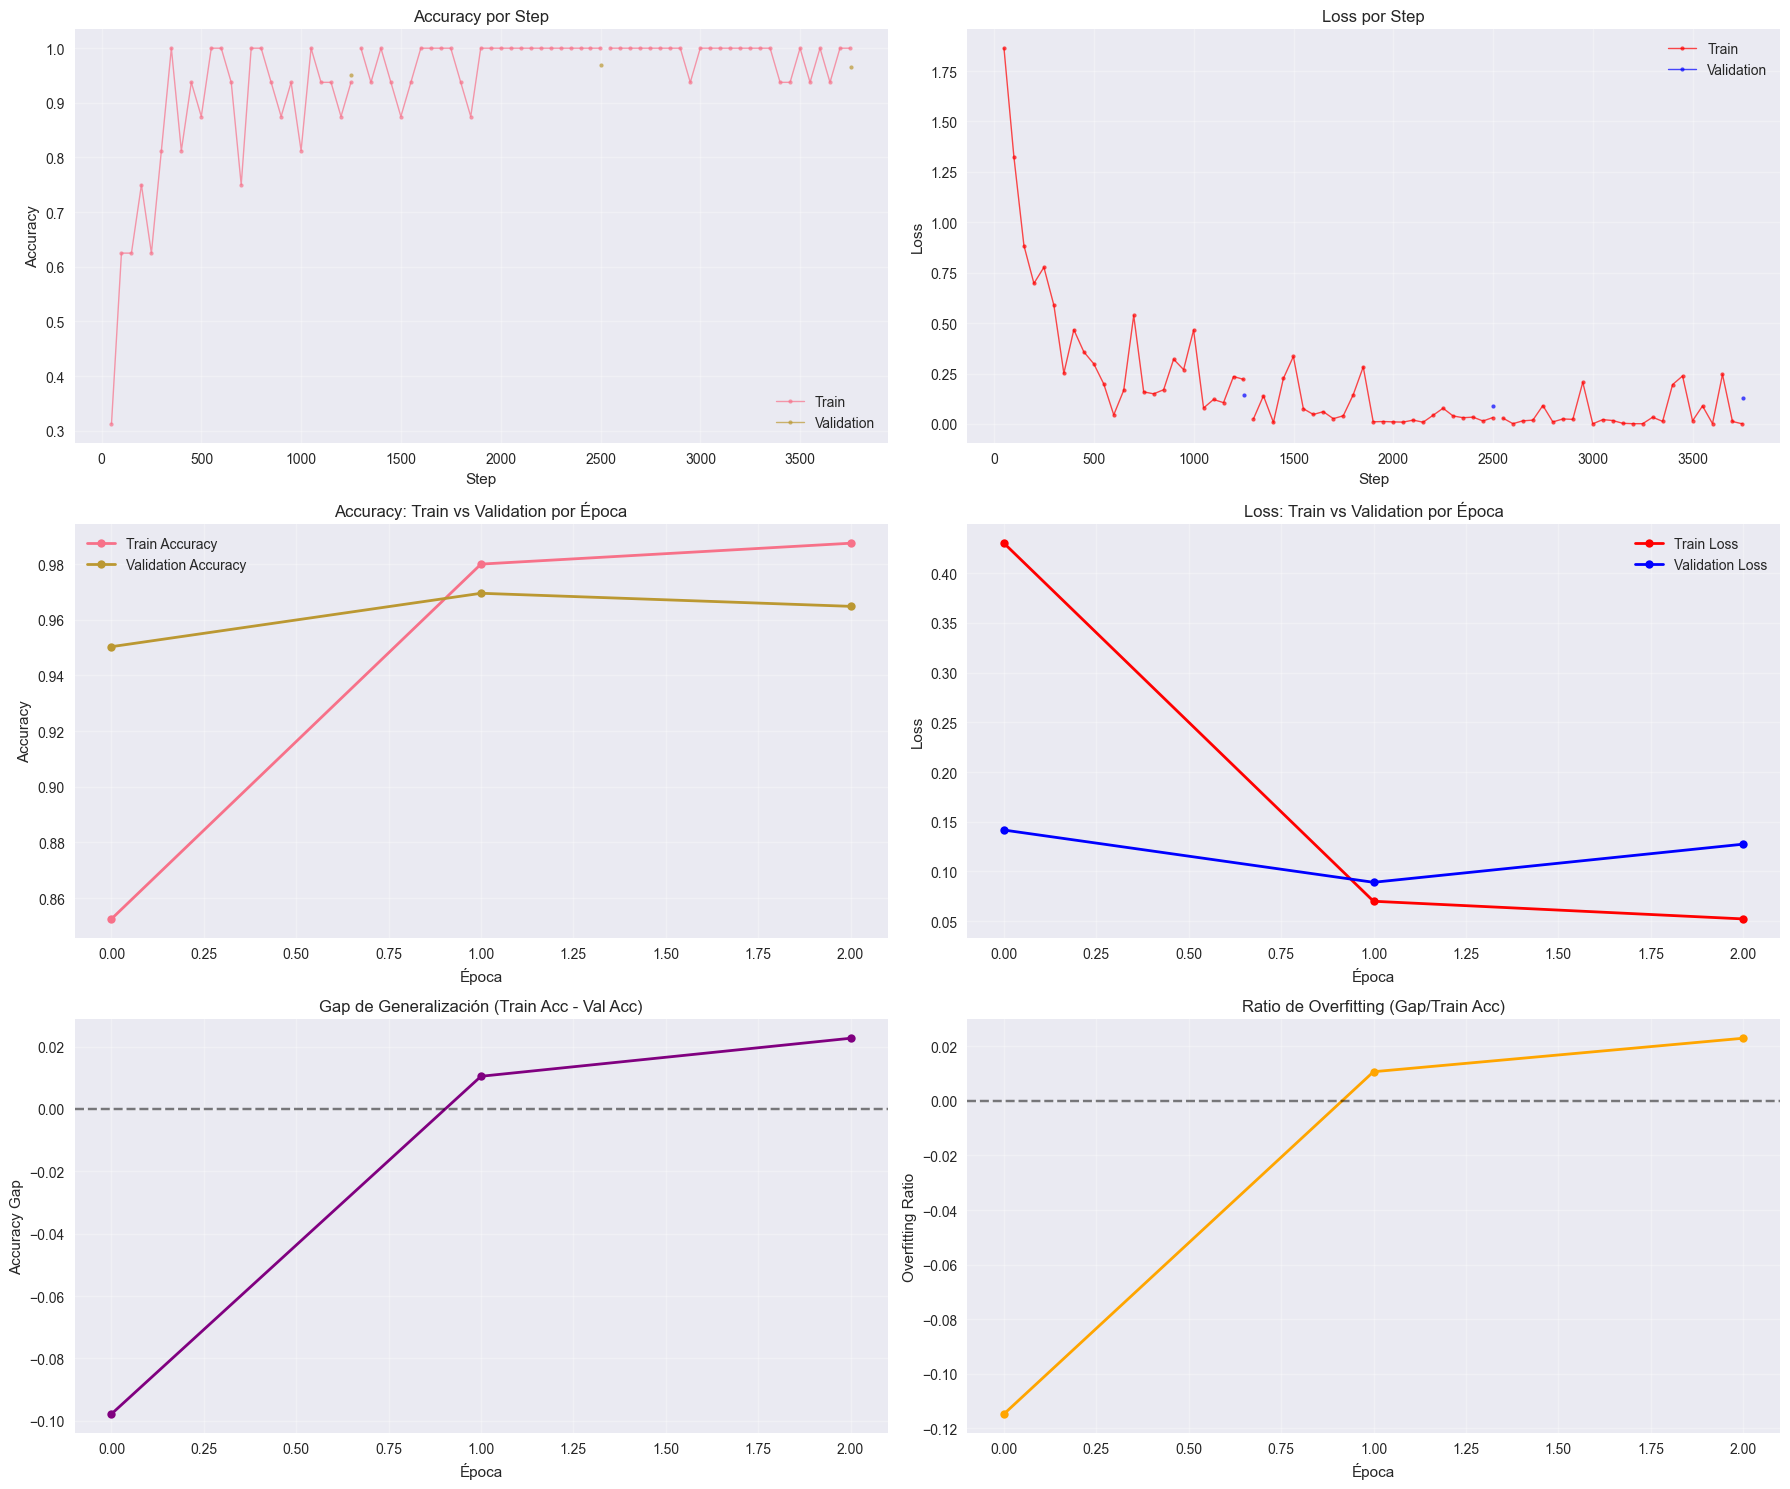

📊 ESTADÍSTICAS COMPLETAS DE ENTRENAMIENTO:
   • Train Accuracy: 0.940 ± 0.116
   • Train Loss: 0.184 ± 0.305
   • Validation Accuracy: 0.962 ± 0.010
   • Validation Loss: 0.119 ± 0.027
   • Accuracy Gap: -0.022 (train > val)
   • Best Validation Accuracy: 0.970
   • Best Train Accuracy: 1.000
   • Best Train Loss: 0.000


,epoch,step,train_acc,train_loss,val_acc,val_loss
0,0,49,0.3125,1.863525,NaN,NaN
1,0,99,0.6250,1.321884,NaN,NaN
2,0,149,0.6250,0.884552,NaN,NaN
3,0,199,0.7500,0.697109,NaN,NaN
4,0,249,0.6250,0.776838,NaN,NaN
...,...,...,...,...,...,...
73,2,3599,1.0000,0.001502,NaN,NaN
74,2,3649,0.9375,0.245662,NaN,NaN
75,2,3699,1.0000,0.012250,NaN,NaN
76,2,3749,1.0000,0.000248,NaN,NaN


In [32]:
import pandas as pd

df = pd.read_csv(r"D:\Ciencias\SIS421-022025\Laboratorios\Laboratorio 6\lightning_logs\version_9\metrics.csv", sep=",")
df.head()

plot_from_dataframe(df)
# plot_comparison_metrics(df)

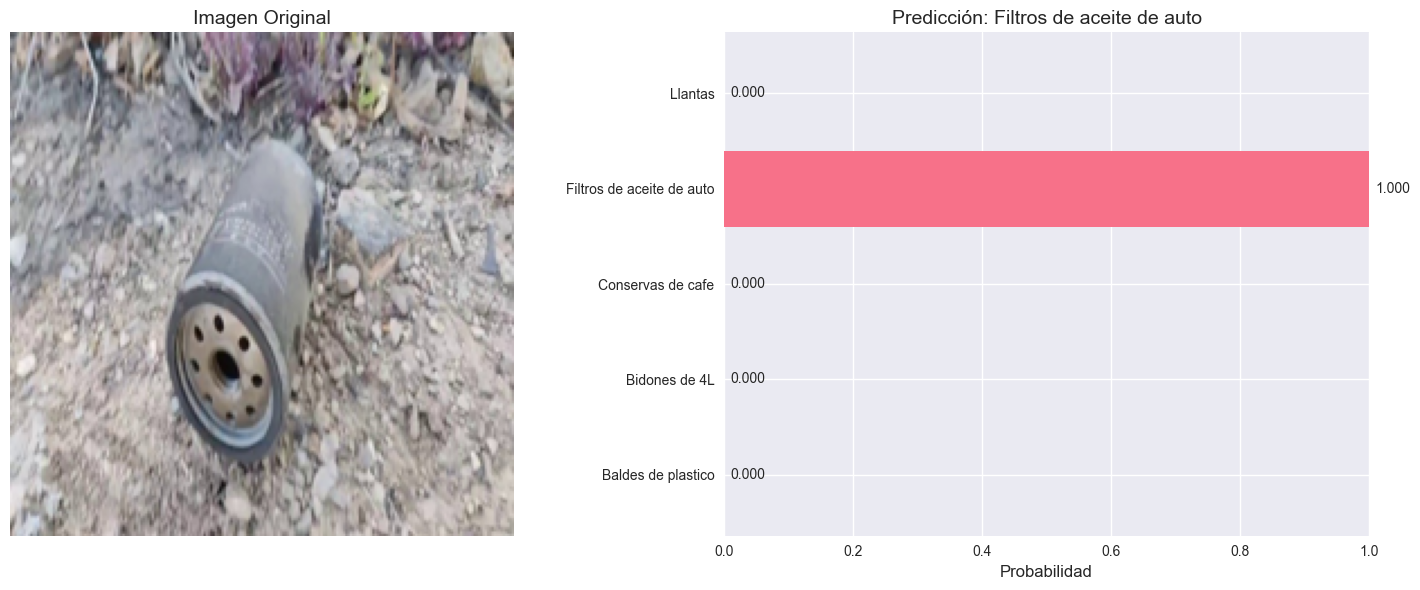

Predicted class: 3, Probabilities: tensor([6.2768e-13, 2.5154e-09, 1.6826e-07, 1.0000e+00, 8.0495e-10])


In [42]:
image_path = r"D:\Ciencias\Dataset Residuos solidos\data\val\Filtros de aceite de auto\0xw7xs5eovwgpl2e.jpg"
# loaded_model = load_model_complete(r"D:\Ciencias\SIS421-022025\Laboratorios\Laboratorio 5\lightning_logs\version_0\checkpoints\epoch=19-step=2340.ckpt")
class_names = [
    'Baldes de plastico', 
    'Bidones de 4L', 
    'Conservas de cafe', 
    'Filtros de aceite de auto', 
    'Llantas'
]
pred_class, pred_probs = visualize_prediction(image_path=image_path, model=model, class_names=class_names)
print(f'Predicted class: {pred_class}, Probabilities: {pred_probs}')

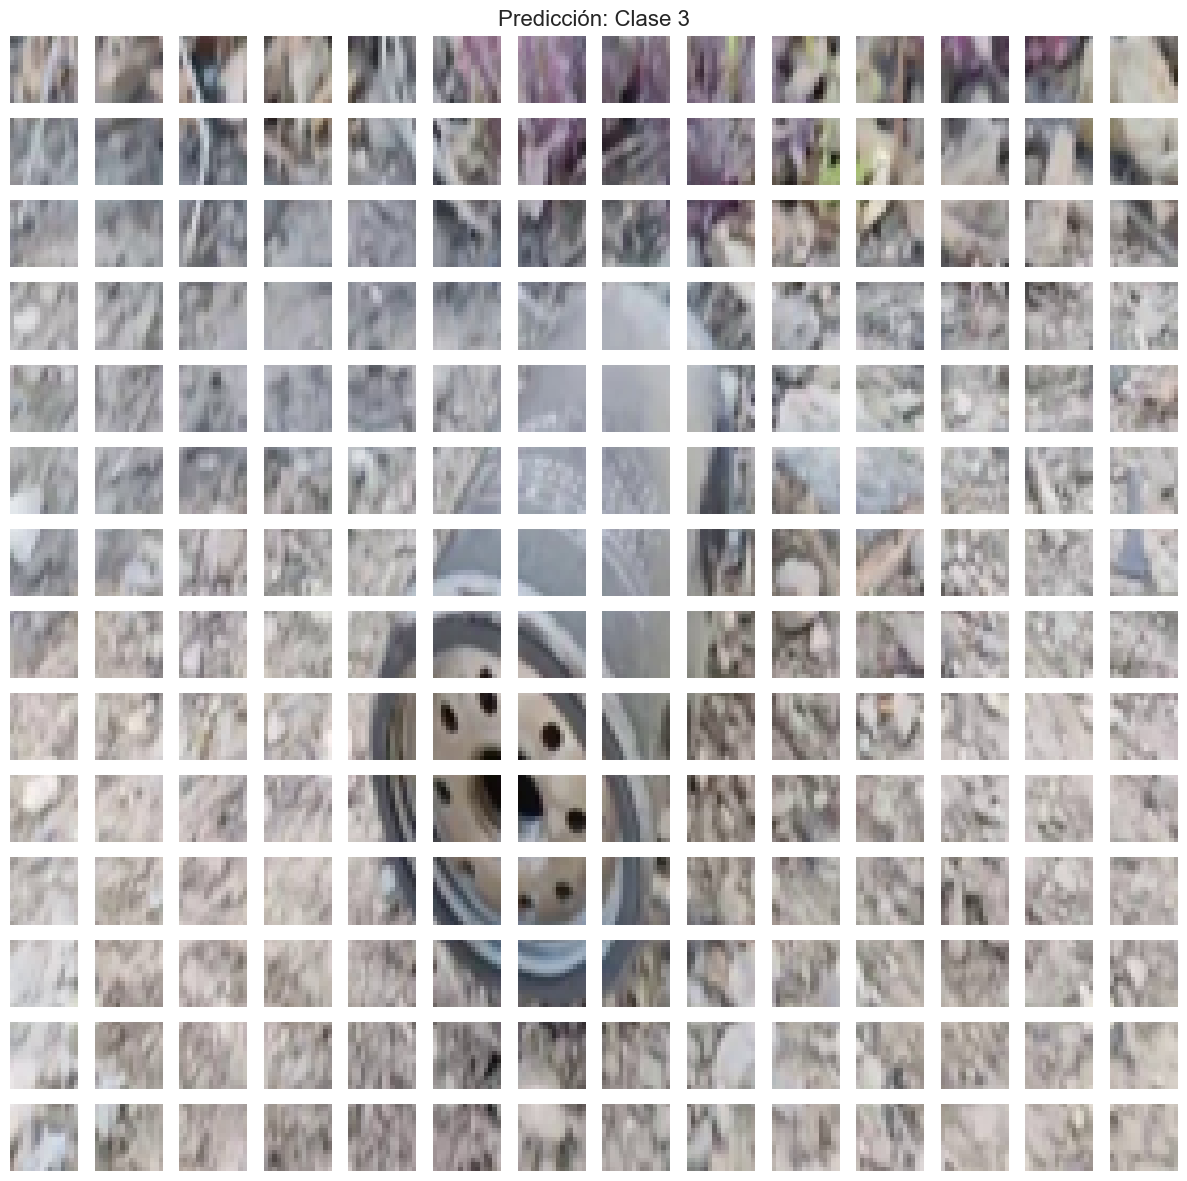

In [40]:
visualize_patches_from_image(image_path=image_path, model=model, patch_size=patch_size)